/tmp/ipykernel_352955/1290034168.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[column].fillna(dataset[column].mean(), inplace=True)


Best training accuracy: 1.0000 at k=1
Best validation accuracy: 0.8437 at k=9


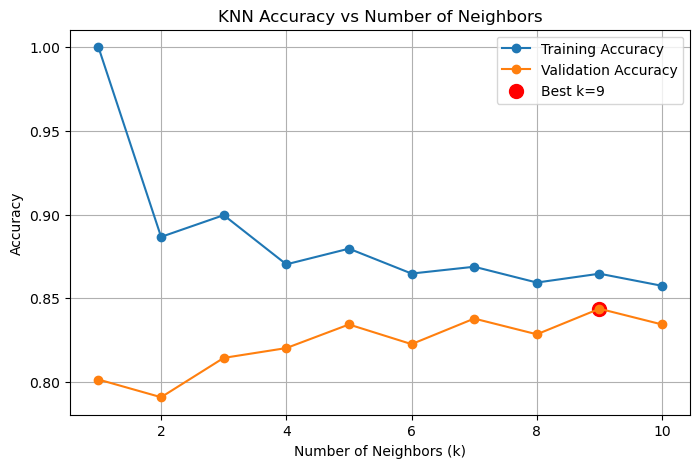

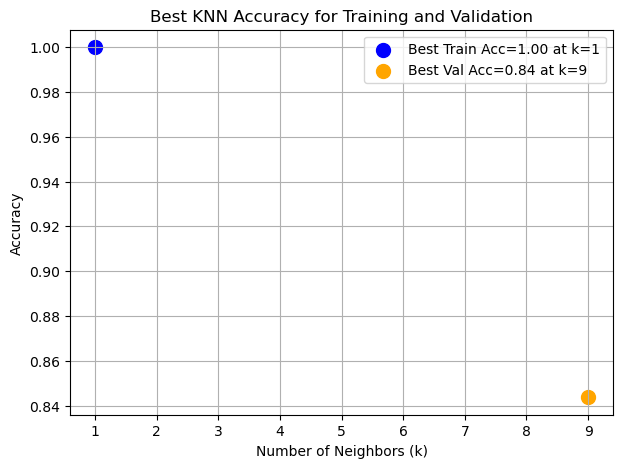


📊 Final Model Performance:
Accuracy : 0.8370
Precision: 0.8400
Recall   : 0.8370
F1 Score : 0.8299


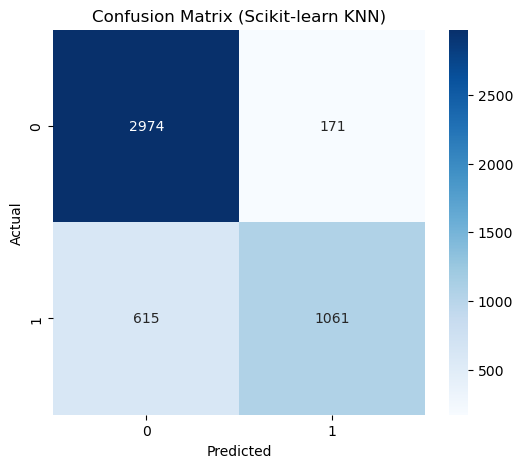

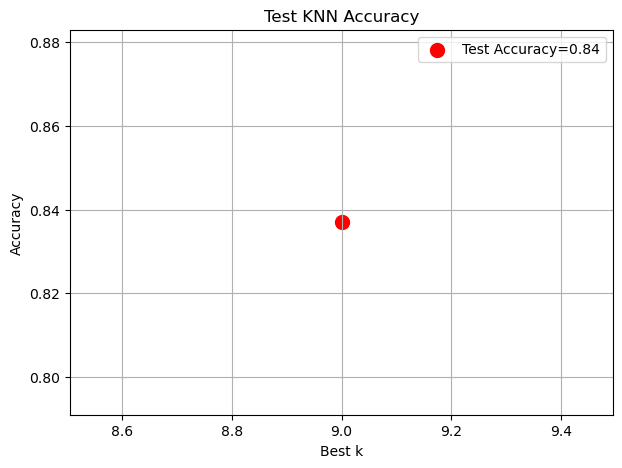


✅ Results saved to 'results_model_using_scikit.json'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  
import seaborn as sns  
import json

Ks = range(1,11)
trn_acc = []
val_acc = []
bestk = 0
testAcc = 0.0

def check_duplicates(dataset):
    return dataset.drop_duplicates()

def check_missing_values(dataset):
    for column in dataset.columns:
        if dataset[column].isnull().sum() > 0:
            dataset[column].fillna(dataset[column].mean(), inplace=True)
    return dataset

def feature_transformatiom(dataset):
    # Robust transform (value - median) / IQR
    for column in dataset.drop('class', axis=1).columns:
        scaler = RobustScaler()
        dataset[column] = scaler.fit_transform(dataset[[column]])
    return dataset

def data_preprocessing(dataset_file):
    dataset = pd.read_csv(dataset_file)
    dataset.drop('Unnamed: 0', axis=1, inplace=True)
    dataset = check_duplicates(dataset)
    dataset = check_missing_values(dataset)
    dataset = feature_transformatiom(dataset)
    return dataset

def knn_classifier(dataset):
    global trn_acc, val_acc, bestk, testAcc

    X = dataset.drop('class', axis=1)
    y = dataset['class']

    training_data_X_full, test_data_X, training_data_y_full, test_data_y = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42)
    test_data_X, validation_data_X, test_data_y, validation_data_y = train_test_split(
        test_data_X, test_data_y, test_size=0.15, stratify=test_data_y, random_state=42)

    min_max_scalar = MinMaxScaler()
    min_max_scalar.fit(training_data_X_full)

    
    validation_data_X = min_max_scalar.transform(validation_data_X)
    training_data_X_full = min_max_scalar.transform(training_data_X_full)
    test_data_X = min_max_scalar.transform(test_data_X)

    training_accuracy = []
    validation_accuracy = []

    k_neighbours = range(1, 11)
    for k in k_neighbours:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(training_data_X_full, training_data_y_full)
        training_accuracy.append(model.score(training_data_X_full, training_data_y_full))
        validation_accuracy.append(model.score(validation_data_X, validation_data_y))

    validation_accuracy = np.array(validation_accuracy)

    best_k_train = np.argmax(training_accuracy) + 1
    best_acc_train = training_accuracy[best_k_train - 1]

    best_k_val = np.argmax(validation_accuracy) + 1
    best_acc_val = validation_accuracy[best_k_val - 1]

    print(f"Best training accuracy: {best_acc_train:.4f} at k={best_k_train}")
    print(f"Best validation accuracy: {best_acc_val:.4f} at k={best_k_val}")

    plt.figure(figsize=(8, 5))
    plt.plot(k_neighbours, training_accuracy, label="Training Accuracy", marker='o')
    plt.plot(k_neighbours, validation_accuracy, label="Validation Accuracy", marker='o')
    plt.scatter(best_k_val, validation_accuracy[best_k_val - 1], color='red', label=f"Best k={best_k_val}", s=100)
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.title("KNN Accuracy vs Number of Neighbors")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot only best points
    plt.figure(figsize=(7, 5))
    plt.scatter(best_k_train, best_acc_train, color='blue', s=100, label=f"Best Train Acc={best_acc_train:.2f} at k={best_k_train}")
    plt.scatter(best_k_val, best_acc_val, color='orange', s=100, label=f"Best Val Acc={best_acc_val:.2f} at k={best_k_val}")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.title("Best KNN Accuracy for Training and Validation")
    plt.legend()
    plt.grid(True)
    plt.show()

    final_model = KNeighborsClassifier(n_neighbors=best_k_val)
    final_model.fit(training_data_X_full, training_data_y_full)
    test_pred = final_model.predict(test_data_X)
    test_accuracy = accuracy_score(test_data_y, test_pred)
    precision = precision_score(test_data_y, test_pred, average='weighted')
    recall = recall_score(test_data_y, test_pred, average='weighted')
    f1 = f1_score(test_data_y, test_pred, average='weighted')
    cm = confusion_matrix(test_data_y, test_pred)

    print("\n📊 Final Model Performance:")
    print(f"Accuracy : {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Scikit-learn KNN)')
    plt.show()

    # Plot test accuracy
    plt.figure(figsize=(7, 5))
    plt.scatter(best_k_val, test_accuracy, color='red', s=100, label=f"Test Accuracy={test_accuracy:.2f}")
    plt.xlabel("Best k")
    plt.ylabel("Accuracy")
    plt.title("Test KNN Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save metrics
    trn_acc = training_accuracy.copy()
    val_acc = validation_accuracy.copy()
    bestk = best_k_val
    testAcc = test_accuracy

    return {
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm.tolist()
    }



dataset = data_preprocessing("telescope_data.csv")
metrics = knn_classifier(dataset)

results = {
    "k_values": list(Ks),
    "training_accuracy": list(trn_acc),
    "validation_accuracy": list(val_acc),
    "best_k": int(bestk),
    "best_val_accuracy": float(testAcc),
    "final_metrics": metrics  
}

# Save to JSON file
with open("results_model_using_scikit.json", "w") as f:
    json.dump(results, f, indent=4)

print("\n✅ Results saved to 'results_model_using_scikit.json'")
